Your Full Name: 
    
`Arindam Choudhury`

    Nutan Mandale
    
    Humberto Gonzalez Granda

Your Uplevel Email Address:
    
    arindam.choudhury.email@gmail.com
    
    nutan.mandale@gmail.com
    
    HumbertoGonzalezGranda@gmail.com

Name of the Problem Statement of Submission:
    
    ShopTalk (Project-6)

In [1]:
import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain_community.vectorstores import FAISS
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_openai import OpenAIEmbeddings, OpenAI
from langchain_huggingface import HuggingFaceEmbeddings
from dotenv import load_dotenv
from src.utils import download_directory_from_s3
import pandas as pd
import streamlit as st
from streamlit_feedback import streamlit_feedback
import os
import time
import json
from PIL import Image
import requests
from io import BytesIO
import shutil

/Users/arindam/Machine Learning/GitHub_Repository/ShopChat_APP/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

genai.configure(api_key = os.getenv("GOOGLE_API_KEY"))      # Set the API key for Google GenAI LLM
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")  # Set the API key for Google Embeddings
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")  # Set the API key for OpenAI LLM and Embeddings

ABO_BUCKET_NAME:      str = os.getenv("ABO_BUCKET_NAME")
YOUR_S3_BUCKET_NAME:  str = os.getenv("YOUR_S3_BUCKET_NAME")
ARTIFACTS_FOLDER:     str = os.getenv("ARTIFACTS_FOLDER")
EDA_FOLDER_NAME:      str = os.getenv("EDA_FOLDER_NAME")
app_artifacts_folder: str = "../artifacts/"
local_folder:         str = "artifacts"

imgae_url:            str = f"https://{ABO_BUCKET_NAME}.s3.amazonaws.com/images/small/"
json_file_s3:         str = f"s3://{YOUR_S3_BUCKET_NAME}/{EDA_FOLDER_NAME}/processed/dataset.json"

GOOGLE_FIASS_DB:      str = "GOOGLE_FAISS_DB"
OPENAI_FAISS_DB:      str = "OPENAI_FAISS_DB"
FINETUNE_FAISS_DB:    str = "FINETUNE_FAISS_DB"

In [3]:
if not os.path.exists(app_artifacts_folder):
    os.makedirs(app_artifacts_folder)

In [4]:
json_file = pd.read_json(json_file_s3)

#### Download FAISS DB in local folder

In [5]:
download_directory_from_s3(YOUR_S3_BUCKET_NAME, GOOGLE_FIASS_DB, app_artifacts_folder) # local_folder in streamlit
download_directory_from_s3(YOUR_S3_BUCKET_NAME, OPENAI_FAISS_DB, app_artifacts_folder) # local_folder in streamlit
download_directory_from_s3(YOUR_S3_BUCKET_NAME, FINETUNE_FAISS_DB, app_artifacts_folder) # local_folder in streamlit

#### Design Prompt

In [6]:
prompt     = ChatPromptTemplate.from_template(
"""

You are a Helpful sales recommender who will have a casual and friendly chat with the buyer to find out what they are looking for.
Always introduce yourself as "ShopChat recommender" but Instead of asking directly what kind of products they are looking for, 
have a casual conversation to understanding the need of the buyer. Don't start the conversation like a salesperson. 
When you are confident that you have enough information, recommend the product to the buyer. You also return possible recommendations 
when you are not fully confident but somewhat confident. 

You will always respond in the JSON schema presented below, always return all fields:

Limit your answer to 16,385 tokens.

{{
    "confidence": "string", # This is where you explain how confident you are in your recommendation, this is only for you, can be low, medium, high
    "recommendation": "list", # This is where you recommend a list of the products to the buyer, only return if your confidence is medium or high. this can only be the name of the product and nothing else. if you are at medium or high confidence always return a recommendation
    "your_response_to_buyer": "string" # This is where you respond to the buyer, this is what the buyer will see. Only recommend the product to the user in this response as list of products if your confidence is high. Always have a response for the user in all cases
    "item_id": "list", # This is where you will add the list of "item_id" from the context documents for the recomanded products.
    "domain_name": "list", # This is where you will add the list of "domain_name" from the context documents for the recomanded products.
    "image_id": "list", # This is where you will add the list of "path" from the context documents for the recomanded products.
}}

Here are the products in stock with Amazon:

Answer the questions based on the provided context only, do not make it up if not in context documents.

<context>
{context}
<context>
Questions:{input}

"""
)

#### Define Function to get the image from url

In [7]:
def get_image(image_path):
   
    url = imgae_url + image_path
    response = requests.get(url)
    image_pil = Image.open(BytesIO(response.content))

    return image_pil

#### Query and Model select

In [8]:
query = "can you suggest me a sofa for my living room?"
Options = "google" 
# Options = "openai"
# Options = "finetune"

In [9]:
if Options == "google":
    embeddings = GoogleGenerativeAIEmbeddings(model = "models/embedding-001")
    vector_db  = FAISS.load_local(f"{app_artifacts_folder}{GOOGLE_FIASS_DB}", embeddings, allow_dangerous_deserialization=True)
    retriever  = vector_db.as_retriever()
    LLM        = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0)
if Options == "openai":
    embeddings = OpenAIEmbeddings()
    vector_db  = FAISS.load_local(f"{app_artifacts_folder}{OPENAI_FAISS_DB}", embeddings, allow_dangerous_deserialization=True)
    retriever  = vector_db.as_retriever(ssearch_type="mmr", search_kwargs={'k': 4})
    LLM        = OpenAI(temperature=0)

#### Run llm chain

In [10]:
document_chain  = create_stuff_documents_chain(LLM,prompt)
retrieval_chain = create_retrieval_chain(retriever,document_chain)
start           = time.process_time()
response        = retrieval_chain.invoke({'input':query})
json_response   = json.loads(response['answer'])

#### Print LLM responce 

In [11]:
print(json_response['your_response_to_buyer'])

I would recommend the Amazon Brand – Rivet Thomas Modern Leather Sofa Couch, 81.5"W, Caramel or the Amazon Brand – Stone & Beam Kristin Round Arm Performance Fabric Loveseat Sofa Couch, 76"W, Sand. Both of these sofas are stylish and comfortable, and they would be a great addition to any living room.


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

#### Display product image

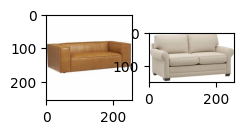

In [13]:
i=1
for item_id, domain_name, image_id in zip(json_response["item_id"], json_response["domain_name"], json_response["image_id"]):
    image_pil = get_image(image_id)
    image_pil.resize((300,300))
    plt.subplot(1, 5, i)
    plt.imshow(image_pil)
    i+=1

More Images
Click the link to buy:  https://www.amazon.com/dp/B071W5VCTH


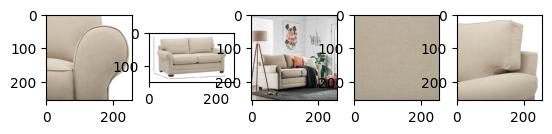

In [14]:
print("More Images")
more_images_paths = json_file[json_file["item_id"] == item_id]["other_image_id_path"].to_list()[0]
more_images = []
for more_images_path in more_images_paths:
    image_pil = get_image(more_images_path)
    image_pil.resize((100,100))
    more_images.append(image_pil)
total = len(more_images)
for i, images in enumerate(more_images):
    plt.subplot(1, total, i+1)
    plt.imshow(images)
print("Click the link to buy:  https://www." + domain_name + "/dp/" + item_id)

#### Remove FAISS DB from local folder

In [15]:
if os.path.exists(f"{app_artifacts_folder}{GOOGLE_FIASS_DB}"):
    shutil.rmtree(f"{app_artifacts_folder}{GOOGLE_FIASS_DB}")
    print("GOOGLE_FIASS_DB folder removed successfully.")
if os.path.exists(f"{app_artifacts_folder}{OPENAI_FAISS_DB}"):
    shutil.rmtree(f"{app_artifacts_folder}{OPENAI_FAISS_DB}")
    print("OPENAI_FAISS_DB folder removed successfully.")

GOOGLE_FIASS_DB folder removed successfully.
